# Instructions  
You will submit an HTML document to Canvas as your final version.  

Your document should show your code chunks/cells as well as any output. Make sure that only relevant output is printed. Do not, for example, print the entire dataset in your final rendered file.  

Your document should also be clearly organized, so that it is easy for a reader to find your answers to each question.  

# The Data  
This week, we consider a dataset generated from text data.  

The original dataset can be found here: https://www.kaggle.com/datasets/kingburrito666/cannabis-strains. It consists of user reviews of different strains of cannabis. Users rated their experience with the cannabis strain on a scale of 1 to 5. They also selected words from a long list to describe the Effects and the Flavor of the cannabis.  

In the dataset linked above, each row is one strain of cannabis. The average rating of all testers is reported, as well as the most commonly used words for the effect and flavor.  

Some data cleaning has been performed for you: The Effect and Flavor columns have been converted to dummy variables indicating if the particular word was used for the particular strain.  

This cleaned data can be found at: https://www.dropbox.com/s/s2a1uoiegitupjc/cannabis_full.csv  

Our goal will be to fit models that identify the Sativa types from the Indica types, and then to fit models that also distinguish the Hybrid types.  

IMPORTANT: In this assignment, you do not need to consider different feature sets. Normally, this would be a good thing to try - but for this homework, simply include all the predictors for every model.  

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold, cross_val_predict
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures, LabelEncoder
from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.metrics import roc_auc_score, precision_score, recall_score, confusion_matrix, roc_curve, classification_report, roc_curve, auc
from plotnine import *
import warnings
from sklearn.exceptions import FitFailedWarning

In [3]:
cannabis = pd.read_csv("cannabis_full.csv")
cannabis.dropna(inplace=True) # Drop rows with missing values
cannabis.head()

,Strain,Type,Rating,Effects,Flavor,Creative,Energetic,Tingly,Euphoric,Relaxed,...,Ammonia,Minty,Tree,Fruit,Butter,Pineapple,Tar,Rose,Plum,Pear
0,100-Og,hybrid,4.0,"Creative,Energetic,Tingly,Euphoric,Relaxed","Earthy,Sweet,Citrus",1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,98-White-Widow,hybrid,4.7,"Relaxed,Aroused,Creative,Happy,Energetic","Flowery,Violet,Diesel",1.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1024,sativa,4.4,"Uplifted,Happy,Relaxed,Energetic,Creative","Spicy/Herbal,Sage,Woody",1.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,13-Dawgs,hybrid,4.2,"Tingly,Creative,Hungry,Relaxed,Uplifted","Apricot,Citrus,Grapefruit",1.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,24K-Gold,hybrid,4.6,"Happy,Relaxed,Euphoric,Uplifted,Talkative","Citrus,Earthy,Orange",0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Part One: Binary Classification  
Create a dataset that is limited only to the Sativa and Indica type cannabis strains.  

This section asks you to create a final best model for each of the four new model types studied this week: LDA, QDA, SVC, and SVM. For SVM, you may limit yourself to only the polynomial kernel.  

For each, you should:  

- Choose a metric you will use to select your model, and briefly justify your choice. (Hint: There is no specific target category here, so this should not be a metric that only prioritizes one category.)  

- Find the best model for predicting the Type variable. Don’t forget to tune any hyperparameters.  

- Report the (cross-validated!) metric.  

- Fit the final model.  

- Output a confusion matrix.  

In [34]:
# Filter for Sativa and Indica
cannabis_binary = cannabis[cannabis['Type'].isin(['sativa', 'indica'])]

# Encode target variable
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(cannabis_binary['Type']) # 0 for indica, 1 for sativa

X = cannabis_binary.drop(columns=['Type', 'Strain', 'Effects', 'Flavor']) # Define predictors, dropping unnecessary columns

## Q1: LDA

In [35]:
lda_pipeline = Pipeline(
  [("scaler", StandardScaler()),
  ("lda", LinearDiscriminantAnalysis())]
)

# Hyperparameter tuning
param_grid = {
    'lda__solver': ['svd', 'lsqr', 'eigen'],
    'lda__shrinkage': [None, 'auto'],
}

stratified_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_search = GridSearchCV(
    lda_pipeline,
    param_grid,
    cv=stratified_cv,
    scoring="accuracy",
    n_jobs=-1,
)

# Use warnings.catch_warnings() to suppress warnings
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=FitFailedWarning)
    warnings.filterwarnings("ignore", category=UserWarning)
    
    # Run the grid search
    grid_search.fit(X, y)
    
print(f"Best Hyperparameters: {grid_search.best_params_}")
print(f"Best Cross-Validated Accuracy: {grid_search.best_score_:.4f}")

Best Hyperparameters: {'lda__shrinkage': 'auto', 'lda__solver': 'lsqr'}
Best Cross-Validated Accuracy: 0.8652


I will be using accuracy to select the model because it measures how often the model correctly predicts both classes overall. Since there is no single category that is more important, accuracy gives a fair way to evaluate the model’s performance. The class imbalance is small, so accuracy still works well to show how well the model handles both categories equally. The best cross-validated accuracy achieved was 0.8652 with the hyperparameters `lda_shrinkage='auto'` and `lda_solver='lsqr'.`

In [37]:
# Define the final pipeline
final_lda_pipeline = Pipeline(
  [("scaler", StandardScaler()),
  ("lda", LinearDiscriminantAnalysis(shrinkage='auto', solver='lsqr'))]
)

# Test performance
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

final_lda_pipeline.fit(X_train, y_train)
y_pred = final_lda_pipeline.predict(X_test)

lda_cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
lda_df = pd.DataFrame(
    lda_cm,
    index=label_encoder.classes_,  # Actual class labels
    columns=label_encoder.classes_  # Predicted class labels
)
print(lda_df)
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

Confusion Matrix:
        indica  sativa
indica     182      16
sativa      20     103
Classification Report:
              precision    recall  f1-score   support

      indica       0.90      0.92      0.91       198
      sativa       0.87      0.84      0.85       123

    accuracy                           0.89       321
   macro avg       0.88      0.88      0.88       321
weighted avg       0.89      0.89      0.89       321



The final LDA model achieved an accuracy of 89%, meaning it correctly predicted the strain type in most cases. The confusion matrix shows it misclassified 16 indica strains as sativa and 20 sativa strains as indica. The recall for indica is 92%, meaning most indica strains were identified correctly, while the recall for sativa is 84%, showing slightly lower performance for this class. Overall, the model works well for both classes and shows good balance in its predictions.

## Q2: QDA

In [38]:
qda_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("qda", QuadraticDiscriminantAnalysis())
])

param_grid = {
    "qda__reg_param": [0.0, 0.01, 0.1, 0.2, 0.5, 0.7, 1.0]  # Regularization parameter
}

# Hyperparameter tuning
grid_search = GridSearchCV(
    qda_pipeline,
    param_grid,
    cv=stratified_cv,
    scoring="accuracy",
    n_jobs=-1
)

# Use warnings.catch_warnings() to suppress "Variables are collinear" warning
warnings.filterwarnings("ignore", message="Variables are collinear")

grid_search.fit(X, y)

best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Best Hyperparameters: {best_params}")
print(f"Best Cross-Validated Accuracy: {best_score:.4f}")

# Define the final pipeline
final_qda_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("qda", QuadraticDiscriminantAnalysis(reg_param=best_params["qda__reg_param"]))
])

# Test performance
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

final_qda_pipeline.fit(X_train, y_train)
y_pred = final_qda_pipeline.predict(X_test)

qda_cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
qda_df = pd.DataFrame(
    qda_cm,
    index=label_encoder.classes_,  # Actual class labels
    columns=label_encoder.classes_  # Predicted class labels
)
print(qda_df)
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))


Best Hyperparameters: {'qda__reg_param': 1.0}
Best Cross-Validated Accuracy: 0.8633
Confusion Matrix:
        indica  sativa
indica     181      17
sativa      17     106
Classification Report:
              precision    recall  f1-score   support

      indica       0.91      0.91      0.91       198
      sativa       0.86      0.86      0.86       123

    accuracy                           0.89       321
   macro avg       0.89      0.89      0.89       321
weighted avg       0.89      0.89      0.89       321



The final QDA model achieved an accuracy of 89%, meaning it correctly predicted the strain type for most cases. The confusion matrix shows it misclassified 17 indica strains as sativa and 17 sativa strains as indica. The recall for indica is 91%, meaning most indica strains were identified correctly, while the recall for sativa is 86%, indicating slightly lower performance for this class. Overall, the model demonstrates strong and balanced performance across both strain types, with good precision and recall scores for both classes.

## Q3: SVC

In [39]:
svc_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("svc", SVC())
])

param_grid = {
    "svc__C": [0.1, 1, 10, 100] # Regularization parameter
}

# Hyperparameter tuning
grid_search = GridSearchCV(
    svc_pipeline,
    param_grid,
    cv=stratified_cv,
    scoring="accuracy",
    n_jobs=-1
)

grid_search.fit(X, y)

best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Best Hyperparameters: {best_params}")
print(f"Best Cross-Validated Accuracy: {best_score:.4f}")

# Define the final pipeline
final_svc_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("svc", SVC(
        C=best_params["svc__C"]
    ))
])

# Test performance
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

final_svc_pipeline.fit(X_train, y_train)
y_pred = final_svc_pipeline.predict(X_test)

# Evaluate the final model
svc_cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
svc_df = pd.DataFrame(
    svc_cm,
    index=label_encoder.classes_,  # Actual class labels
    columns=label_encoder.classes_  # Predicted class labels
)
print(svc_df)
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))


Best Hyperparameters: {'svc__C': 1}
Best Cross-Validated Accuracy: 0.8408
Confusion Matrix:
        indica  sativa
indica     183      15
sativa      26      97
Classification Report:
              precision    recall  f1-score   support

      indica       0.88      0.92      0.90       198
      sativa       0.87      0.79      0.83       123

    accuracy                           0.87       321
   macro avg       0.87      0.86      0.86       321
weighted avg       0.87      0.87      0.87       321



The SVC model achieved an accuracy of 87%, correctly predicting the strain type in most cases. The confusion matrix shows it misclassified 15 indica strains as sativa and 26 sativa strains as indica. The recall for indica is 92%, indicating strong performance in identifying indica strains, while the recall for sativa is lower at 79%, showing more difficulty with this class. Overall, the model demonstrates strong performance, with high accuracy and recall for the indica class.

## Q4: SVM

In [40]:
svm_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("svm", SVC())
])

# Define the hyperparameter grid for polynomial kernel only
param_grid = {
    "svm__C": [0.1, 1, 10, 100],          # Regularization parameter
    "svm__kernel": ["poly"],              # Polynomial kernel
    "svm__degree": [2, 3, 4],             # Degree of the polynomial kernel
    "svm__gamma": ["scale", "auto"]       # Kernel coefficient
}

grid_search = GridSearchCV(
    svm_pipeline,
    param_grid,
    cv=stratified_cv,
    scoring="accuracy",
    n_jobs=-1
)

grid_search.fit(X, y)

best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Best Hyperparameters: {best_params}")
print(f"Best Cross-Validated Accuracy: {best_score:.4f}")

# Define the final pipeline
final_svm_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("svm", SVC(
        kernel="poly",
        C=best_params["svm__C"],
        degree=best_params["svm__degree"],
        gamma=best_params["svm__gamma"]
    ))
])

# Test performance
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

final_svm_pipeline.fit(X_train, y_train)
y_pred = final_svm_pipeline.predict(X_test)

# Evaluate the final model
svm_cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
svm_df = pd.DataFrame(
    svm_cm,
    index=label_encoder.classes_,  # Actual class labels
    columns=label_encoder.classes_  # Predicted class labels
)
print(svm_df)
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))


Best Hyperparameters: {'svm__C': 10, 'svm__degree': 3, 'svm__gamma': 'scale', 'svm__kernel': 'poly'}
Best Cross-Validated Accuracy: 0.8315
Confusion Matrix:
        indica  sativa
indica     175      23
sativa      33      90
Classification Report:
              precision    recall  f1-score   support

      indica       0.84      0.88      0.86       198
      sativa       0.80      0.73      0.76       123

    accuracy                           0.83       321
   macro avg       0.82      0.81      0.81       321
weighted avg       0.82      0.83      0.82       321



The SVM model with the polynomial kernel achieved an accuracy of 83%, correctly predicting the strain type for most test cases. The confusion matrix shows it misclassified 23 indica strains as sativa and 33 sativa strains as indica. The recall for indica is 88%, meaning the model performed well in identifying most indica strains, while the recall for sativa is lower at 73%, indicating more difficulty with this class. Overall, the model shows good performance, but its accuracy and recall for sativa could be improved.

# Part Two: Natural Multiclass  
Now use the full dataset, including the Hybrid strains.  

## Q1  
Fit a decision tree, plot the final fit, and interpret the results.

In [43]:
# Prepare the data
y = label_encoder.fit_transform(cannabis['Type']) # 0: hybrid, 1: indica, 2: sativa

X = cannabis.drop(columns=['Type', 'Strain', 'Effects', 'Flavor']) # Define predictors, dropping unnecessary columns

In [44]:
dt_pipeline = Pipeline([
    ("scaler", StandardScaler()),  # Normalize features
    ("dt", DecisionTreeClassifier(random_state=42))
])

# Define parameter grid
param_grid = {
    "dt__max_depth": [2, 4, 6, 8, 10, None],
    "dt__min_samples_split": [2, 5, 10],
    "dt__min_samples_leaf": [1, 2, 4],
    "dt__ccp_alpha": [0.0, 0.005, 0.01, 0.02, 0.1]
}

grid_search = GridSearchCV(
    dt_pipeline,
    param_grid,
    cv=stratified_cv,
    scoring="accuracy",
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Best Parameters: {best_params}")
print(f"Best Cross-Validated Accuracy: {best_score:.4f}")

# Define the final pipeline
final_dt_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("dt", DecisionTreeClassifier(
        max_depth=best_params["dt__max_depth"],
        min_samples_split=best_params["dt__min_samples_split"],
        min_samples_leaf=best_params["dt__min_samples_leaf"],
        ccp_alpha=best_params["dt__ccp_alpha"],
        random_state=42
    ))
])

# Test performance
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

final_dt_pipeline.fit(X_train, y_train)
y_pred = final_dt_pipeline.predict(X_test)

# Evaluate the final model
dt_cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
dt_df = pd.DataFrame(
    dt_cm,
    index=label_encoder.classes_,  # Actual class labels
    columns=label_encoder.classes_  # Predicted class labels
)
print(dt_df)
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

Best Parameters: {'dt__ccp_alpha': 0.005, 'dt__max_depth': 4, 'dt__min_samples_leaf': 1, 'dt__min_samples_split': 2}
Best Cross-Validated Accuracy: 0.6425
Confusion Matrix:
        hybrid  indica  sativa
hybrid     225      70      42
indica      62     133       3
sativa      74      12      37
Classification Report:
              precision    recall  f1-score   support

      hybrid       0.62      0.67      0.64       337
      indica       0.62      0.67      0.64       198
      sativa       0.45      0.30      0.36       123

    accuracy                           0.60       658
   macro avg       0.56      0.55      0.55       658
weighted avg       0.59      0.60      0.59       658



The decision tree achieved an accuracy of 60%, meaning it correctly predicted 60% of the samples in the test dataset. From the confusion matrix, we see that it performed best on Hybrid and Indica strains, correctly identifying most of them, but struggled with Sativa strains, where only 37 out of 123 were predicted correctly. The precision, recall, and F1-scores show that the model is more reliable for Hybrid and Indica than for Sativa. Overall, the model does a decent job but could use some improvements, especially to handle Sativa strains better.

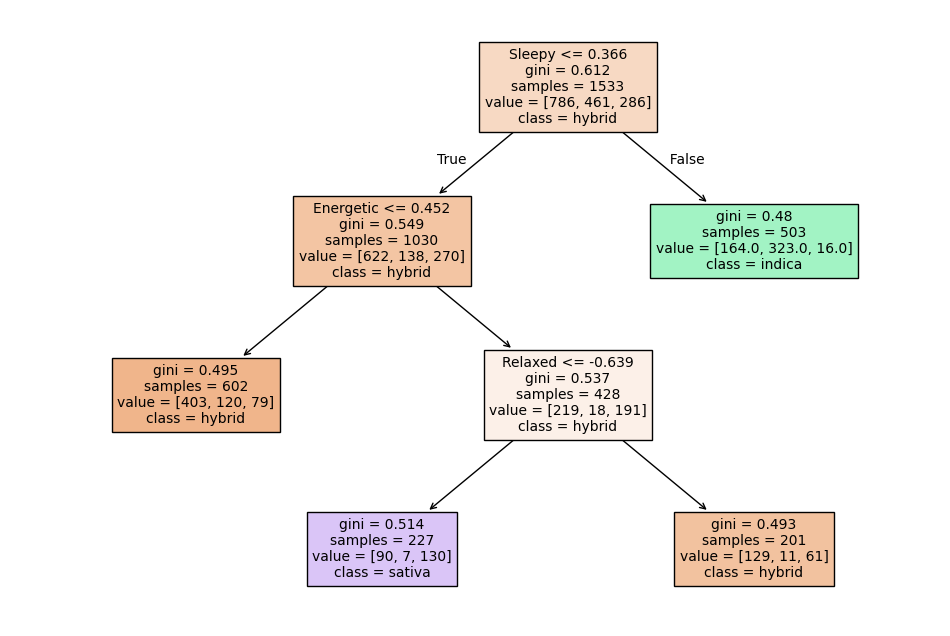

In [12]:
# Plot the decision tree
dt = final_dt_pipeline.named_steps["dt"]  # Extract the tree from the pipeline
plt.figure(figsize=(12, 8))
plot_tree(dt, feature_names=X.columns, class_names=label_encoder.classes_, filled=True, fontsize=10)
plt.show()

The decision tree uses features like "Sleepy," "Energetic," and "Relaxed" to decide if a strain is Hybrid, Indica, or Sativa. The first split is based on the "Sleepy" feature, separating most Hybrid strains from Indica strains. Additional splits, like "Energetic" and "Relaxed," help refine the predictions. Hybrid strains dominate the tree, while Sativa strains are harder to classify accurately. This shows the tree relies heavily on these features but has trouble clearly separating Sativa from the other types.

## Q2  
Repeat the analyses from Part One for LDA, QDA, and KNN.  

### LDA

In [13]:
lda_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("lda", LinearDiscriminantAnalysis())
])

# Define hyperparameter grid
param_grid = {
    "lda__solver": ["svd", "lsqr", "eigen"],
    "lda__shrinkage": [None, "auto"]
}

stratified_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_search = GridSearchCV(
    lda_pipeline,
    param_grid,
    cv=stratified_cv,
    scoring="accuracy",
    n_jobs=-1
)

# Fit the model
# Use warnings.catch_warnings() to suppress warnings
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=FitFailedWarning)
    warnings.filterwarnings("ignore", category=UserWarning)
    
    # Run the grid search
    grid_search.fit(X, y)
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Best Parameters: {best_params}")
print(f"Best Cross-Validated Accuracy: {best_score:.4f}")

# Define the final pipeline
final_lda_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("lda", LinearDiscriminantAnalysis(
        solver=best_params["lda__solver"],
        shrinkage=best_params["lda__shrinkage"]
    ))
])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

# Fit the final model
final_lda_pipeline.fit(X_train, y_train)
y_pred = final_lda_pipeline.predict(X_test)

# Evaluate the model
lda_cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
lda_df = pd.DataFrame(
    lda_cm,
    index=label_encoder.classes_,  # Actual class labels
    columns=label_encoder.classes_  # Predicted class labels
)
print(lda_df)
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))


Best Parameters: {'lda__shrinkage': None, 'lda__solver': 'svd'}
Best Cross-Validated Accuracy: 0.6271
Confusion Matrix:
        hybrid  indica  sativa
hybrid     217      68      52
indica      65     128       5
sativa      72       9      42
Classification Report:
              precision    recall  f1-score   support

      hybrid       0.61      0.64      0.63       337
      indica       0.62      0.65      0.64       198
      sativa       0.42      0.34      0.38       123

    accuracy                           0.59       658
   macro avg       0.55      0.54      0.55       658
weighted avg       0.58      0.59      0.58       658



The LDA model achieved an accuracy of 59%, performing best on Hybrid and Indica strains but struggling significantly with Sativa, where only 42 out of 123 samples were predicted correctly. Precision, recall, and F1-scores show the model is more reliable for Hybrid and Indica than for Sativa. Overall, the model does a moderate job but needs improvement, especially in distinguishing Sativa strains. The results are similar to the results of the decision tree model.

### QDA

In [14]:
qda_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("qda", QuadraticDiscriminantAnalysis())
])

# Define hyperparameter grid
param_grid = {
    "qda__reg_param": [0.0, 0.01, 0.1, 0.2, 0.5, 0.7, 1.0]  # Regularization parameter
}

grid_search = GridSearchCV(
    qda_pipeline,
    param_grid,
    cv=stratified_cv,
    scoring="accuracy",
    n_jobs=-1
)

# Use warnings.catch_warnings() to suppress "Variables are collinear" warning
warnings.filterwarnings("ignore", message="Variables are collinear")
# Fit the grid search
grid_search.fit(X, y)
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Best Parameters: {best_params}")
print(f"Best Cross-Validated Accuracy: {best_score:.4f}")

# Define the final pipeline
final_qda_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("qda", QuadraticDiscriminantAnalysis(reg_param=best_params["qda__reg_param"]))
])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

# Fit the final model
final_qda_pipeline.fit(X_train, y_train)
y_pred = final_qda_pipeline.predict(X_test)

# Evaluate the final model
qda_cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
qda_df = pd.DataFrame(
    qda_cm,
    index=label_encoder.classes_,  # Actual class labels
    columns=label_encoder.classes_  # Predicted class labels
)
print(qda_df)
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))


Best Parameters: {'qda__reg_param': 1.0}
Best Cross-Validated Accuracy: 0.6244
Confusion Matrix:
        hybrid  indica  sativa
hybrid     212      69      56
indica      63     128       7
sativa      67       7      49
Classification Report:
              precision    recall  f1-score   support

      hybrid       0.62      0.63      0.62       337
      indica       0.63      0.65      0.64       198
      sativa       0.44      0.40      0.42       123

    accuracy                           0.59       658
   macro avg       0.56      0.56      0.56       658
weighted avg       0.59      0.59      0.59       658



The QDA model achieved an accuracy of 59%, performing best on Hybrid and Indica strains but struggling significantly with Sativa, where only 49 out of 123 samples were predicted correctly. Precision, recall, and F1-scores show the model is more reliable for Hybrid and Indica than for Sativa. Like the Decison Tree and LDA Models, the model does a moderate job but needs improvement, especially in distinguishing Sativa strains.

### KNN

In [15]:
knn_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("knn", KNeighborsClassifier())
])

# Define hyperparameter grid
param_grid = {'knn__n_neighbors': range(1, 21)}

# Perform hyperparameter tuning
grid_search = GridSearchCV(
    knn_pipeline,
    param_grid,
    cv=stratified_cv,
    scoring="accuracy",
    n_jobs=-1
)

# Fit the model
grid_search.fit(X, y)

best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Best Parameters: {best_params}")
print(f"Best Cross-Validated Accuracy: {best_score:.4f}")

# Define the final pipeline with best parameters
final_knn_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("knn", KNeighborsClassifier(
        n_neighbors=best_params["knn__n_neighbors"]
    ))
])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

# Fit the final model
final_knn_pipeline.fit(X_train, y_train)
y_pred = final_knn_pipeline.predict(X_test)

# Evaluate the final model
knn_cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
knn_df = pd.DataFrame(
    knn_cm,
    index=label_encoder.classes_,  # Actual class labels
    columns=label_encoder.classes_  # Predicted class labels
)
print(knn_df)
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))


Best Parameters: {'knn__n_neighbors': 19}
Best Cross-Validated Accuracy: 0.5851
Confusion Matrix:
        hybrid  indica  sativa
hybrid     271      53      13
indica     101      97       0
sativa      98      14      11
Classification Report:
              precision    recall  f1-score   support

      hybrid       0.58      0.80      0.67       337
      indica       0.59      0.49      0.54       198
      sativa       0.46      0.09      0.15       123

    accuracy                           0.58       658
   macro avg       0.54      0.46      0.45       658
weighted avg       0.56      0.58      0.53       658



The KNN model achieved an accuracy of 58%, performing best on Hybrid strains but struggling significantly with Sativa, where only 11 out of 123 samples were predicted correctly. Precision, recall, and F1-scores show the model is more reliable for Hybrid and Indica strains than for Sativa. Similar to all of the other models in Part Two, KNN does a moderate job but needs significant improvement, especially in identifying Sativa strains.

## Q3  
Were your metrics better or worse than in Part One? Why? Which categories were most likely to get mixed up, according to the confusion matrices? Why?

The metrics in Part Two were much worse compared to Part One. This is likely because the dataset became more complex with the addition of the Hybrid category. Hybrids often combine characteristics of both Sativa and Indica, which makes it harder for models to classify them correctly. Sativa was the most difficult to classify, with very low recall and F1-scores, as it was often confused with Hybrid or Indica. This confusion probably happens because Sativa shares some effects with the other strains. While Hybrid and Indica had better results than Sativa, the models still struggled to consistently distinguish between all three categories.

# Part Three: Multiclass from Binary  
Consider two models designed for binary classification: SVC and Logistic Regression.

## Q1  
Fit and report metrics for OvR versions of the models. That is, for each of the two model types, create three models:  

- Indica vs. Not Indica  

- Sativa vs. Not Sativa  

- Hybrid vs. Not Hybrid  

### SVC

In [52]:
def svc_ovr(X, y, labels, target_label):
    """
    One-vs-Rest (OvR) classification for SVC with stratified cross-validation and labeled outputs.
    
    Parameters:
    - X: pandas DataFrame of feature variables
    - y: pandas Series of target variable
    - labels: list of string labels corresponding to the classes
    - target_label: string description of the OvR comparison
    
    Returns:
    - None: Prints best parameters, accuracy, confusion matrix, and classification report.
    """

    # Define pipeline
    svc_pipeline = Pipeline([
        ("scaler", StandardScaler()),
        ("svc", SVC())
    ])
    
    # Define parameter grid
    param_grid = {
        "svc__C": [0.1, 1, 10, 100]
    }
    
    # Perform grid search
    grid_search = GridSearchCV(
        svc_pipeline,
        param_grid,
        cv=stratified_cv,
        scoring="accuracy",
        n_jobs=-1
    )
    
    # Fit the model
    grid_search.fit(X, y)
    
    # Print best parameters and accuracy
    print(f"{target_label} Results:")
    print(f"Best Parameters: {grid_search.best_params_}")
    print(f"Best Cross-Validated Accuracy: {grid_search.best_score_:.4f}")
    
    # Evaluate on test data
    final_svc_pipeline = Pipeline([
        ("scaler", StandardScaler()),
        ("svc", SVC(C=grid_search.best_params_["svc__C"]))
    ])
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
    final_svc_pipeline.fit(X_train, y_train)
    y_pred = final_svc_pipeline.predict(X_test)
    
    # Confusion matrix and classification report with labels
    svc_cm = confusion_matrix(y_test, y_pred)
    svc_df = pd.DataFrame(
        svc_cm,
        index=labels,  # Actual class labels
        columns=labels  # Predicted class labels
    )
    print("Confusion Matrix:")
    print(svc_df)
    print("Classification Report:")
    print(classification_report(y_test, y_pred, target_names=labels))

In [53]:
# Indica vs. Not Indica
y_indica = (cannabis['Type'] == 'indica').astype(int)  # Binary target for Indica
svc_ovr(X, y_indica, ["Not Indica", "Indica"], "Indica vs. Not Indica")

Indica vs. Not Indica Results:
Best Parameters: {'svc__C': 1}
Best Cross-Validated Accuracy: 0.7773
Confusion Matrix:
            Not Indica  Indica
Not Indica         410      50
Indica              88     110
Classification Report:
              precision    recall  f1-score   support

  Not Indica       0.82      0.89      0.86       460
      Indica       0.69      0.56      0.61       198

    accuracy                           0.79       658
   macro avg       0.76      0.72      0.74       658
weighted avg       0.78      0.79      0.78       658



In [54]:
# Sativa vs. Not Sativa
y_sativa = (cannabis['Type'] == 'sativa').astype(int)
svc_ovr(X, y_sativa, ["Not Sativa", "Sativa"], "Sativa vs. Not Sativa")

Sativa vs. Not Sativa Results:
Best Parameters: {'svc__C': 1}
Best Cross-Validated Accuracy: 0.8202
Confusion Matrix:
            Not Sativa  Sativa
Not Sativa         518      17
Sativa             104      19
Classification Report:
              precision    recall  f1-score   support

  Not Sativa       0.83      0.97      0.90       535
      Sativa       0.53      0.15      0.24       123

    accuracy                           0.82       658
   macro avg       0.68      0.56      0.57       658
weighted avg       0.78      0.82      0.77       658



In [55]:
# Hybrid vs. Not Hybrid
y_hybrid = (cannabis['Type'] == 'hybrid').astype(int)
svc_ovr(X, y_hybrid, ["Not Hybrid", "Hybrid"], "Hybrid vs. Not Hybrid")

Hybrid vs. Not Hybrid Results:
Best Parameters: {'svc__C': 1}
Best Cross-Validated Accuracy: 0.6194
Confusion Matrix:
            Not Hybrid  Hybrid
Not Hybrid         189     132
Hybrid             109     228
Classification Report:
              precision    recall  f1-score   support

  Not Hybrid       0.63      0.59      0.61       321
      Hybrid       0.63      0.68      0.65       337

    accuracy                           0.63       658
   macro avg       0.63      0.63      0.63       658
weighted avg       0.63      0.63      0.63       658



### Logistic Regression

In [60]:
def logreg_ovr(X, y, labels, target_label):
    """
    One-vs-Rest (OvR) classification for Logistic Regression with stratified cross-validation 
    and labeled outputs for the confusion matrix and classification report.
    
    Parameters:
    - X: pandas DataFrame of feature variables
    - y: pandas Series of target variable
    - labels: list of string labels corresponding to the classes
    - target_label: string description of the OvR comparison
    
    Returns:
    - None: Prints best parameters, accuracy, confusion matrix, and classification report.
    """

    # Define pipeline
    logreg_pipeline = Pipeline([
        ("scaler", StandardScaler()),
        ("logreg", LogisticRegression(max_iter=500))
    ])
    
    # Define parameter grid
    param_grid = {
        "logreg__C": [0.01, 0.1, 1, 10, 100],  # Regularization strength
        "logreg__penalty": ["l1", "l2"],       # Regularization type
        "logreg__solver": ["liblinear"]       # Solver for l1 and l2 penalties
    }
    
    # Perform grid search
    grid_search = GridSearchCV(
        logreg_pipeline,
        param_grid,
        cv=stratified_cv,
        scoring="accuracy",
        n_jobs=-1
    )
    
    # Fit the model
    grid_search.fit(X, y)
    
    # Print best parameters and accuracy
    print(f"{target_label} Results:")
    print(f"Best Parameters: {grid_search.best_params_}")
    print(f"Best Cross-Validated Accuracy: {grid_search.best_score_:.4f}")
    
    # Evaluate on test data
    final_logreg_pipeline = Pipeline([
        ("scaler", StandardScaler()),
        ("logreg", LogisticRegression(
            C=grid_search.best_params_["logreg__C"],
            penalty=grid_search.best_params_["logreg__penalty"],
            solver=grid_search.best_params_["logreg__solver"]
        ))
    ])
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
    final_logreg_pipeline.fit(X_train, y_train)
    y_pred = final_logreg_pipeline.predict(X_test)
    
    # Confusion matrix and classification report with labels
    logreg_cm = confusion_matrix(y_test, y_pred)
    logreg_df = pd.DataFrame(
        logreg_cm,
        index=labels,  # Actual class labels
        columns=labels  # Predicted class labels
    )
    print("Confusion Matrix:")
    print(logreg_df)
    print("Classification Report:")
    print(classification_report(y_test, y_pred, target_names=labels))

In [61]:
# Indica vs. Not Indica
logreg_ovr(X, y_indica, ["Not Indica", "Indica"], "Indica vs. Not Indica")

Indica vs. Not Indica Results:
Best Parameters: {'logreg__C': 0.1, 'logreg__penalty': 'l2', 'logreg__solver': 'liblinear'}
Best Cross-Validated Accuracy: 0.7987
Confusion Matrix:
            Not Indica  Indica
Not Indica         402      58
Indica              65     133
Classification Report:
              precision    recall  f1-score   support

  Not Indica       0.86      0.87      0.87       460
      Indica       0.70      0.67      0.68       198

    accuracy                           0.81       658
   macro avg       0.78      0.77      0.78       658
weighted avg       0.81      0.81      0.81       658



In [62]:
# Sativa vs. Not Sativa
logreg_ovr(X, y_sativa, ["Not Sativa", "Sativa"], "Sativa vs. Not Sativa")

Sativa vs. Not Sativa Results:
Best Parameters: {'logreg__C': 0.1, 'logreg__penalty': 'l2', 'logreg__solver': 'liblinear'}
Best Cross-Validated Accuracy: 0.8270
Confusion Matrix:
            Not Sativa  Sativa
Not Sativa         499      36
Sativa              90      33
Classification Report:
              precision    recall  f1-score   support

  Not Sativa       0.85      0.93      0.89       535
      Sativa       0.48      0.27      0.34       123

    accuracy                           0.81       658
   macro avg       0.66      0.60      0.62       658
weighted avg       0.78      0.81      0.79       658



In [63]:
# Hybrid vs. Not Hybrid
logreg_ovr(X, y_hybrid, ["Not Hybrid", "Hybrid"], "Hybrid vs. Not Hybrid")

Hybrid vs. Not Hybrid Results:
Best Parameters: {'logreg__C': 0.1, 'logreg__penalty': 'l1', 'logreg__solver': 'liblinear'}
Best Cross-Validated Accuracy: 0.6303
Confusion Matrix:
            Not Hybrid  Hybrid
Not Hybrid         180     141
Hybrid              94     243
Classification Report:
              precision    recall  f1-score   support

  Not Hybrid       0.66      0.56      0.61       321
      Hybrid       0.63      0.72      0.67       337

    accuracy                           0.64       658
   macro avg       0.64      0.64      0.64       658
weighted avg       0.64      0.64      0.64       658



The OVR results show that the Logistic Regression models performed slightly better than the SVC models.

## Q2  
Which of the six models did the best job distinguishing the target category from the rest? Which did the worst? Does this make intuitive sense?

The results show that "Sativa vs. Not Sativa" was the easiest to classify, as both SVC and Logistic Regression had higher accuracy, precision, and recall. On the other hand, "Hybrid vs. Not Hybrid" was the hardest, with the lowest performance for both models. This makes sense because Hybrid strains combine traits from both Sativa and Indica, making them harder to separate, while Sativa has more distinct features that set it apart.

## Q3  
Fit and report metrics for OvO versions of the models. That is, for each of the two model types, create three models:  

- Indica vs. Sativa  

- Indica vs. Hybrid  

- Hybrid vs. Sativa  

### SVC

In [68]:
def svc_ovo(X, y, class_pair, description, class_labels):
    """
    Perform one-vs-one (OvO) classification with SVC for a given pair of classes.

    Parameters:
    ----------
    X : array-like of shape (n_samples, n_features)
        The feature matrix.
    y : array-like of shape (n_samples,)
        The target variable containing the class labels.
    class_pair : list of int
        A list containing the two class labels for OvO classification.
        Example: [0, 1] for "Indica vs. Sativa".
    description : str
        A string description of the OvO analysis being performed (e.g., "Indica vs. Sativa").
    class_labels : list of str
        A list containing the string labels for the classes in `class_pair`.
        Example: ["Indica", "Sativa"].

    Returns:
    -------
    None
        Prints the best parameters, cross-validated accuracy, confusion matrix, and classification report.
    """

    # Filter for the two classes in the pair
    X_pair = X[y.isin(class_pair)]
    y_pair = y[y.isin(class_pair)]

    # Binary labels for the two classes
    y_pair = np.where(y_pair == class_pair[0], 0, 1)

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X_pair, y_pair, test_size=0.3, stratify=y_pair, random_state=42)

    # Define pipeline
    svc_pipeline = Pipeline([
        ("scaler", StandardScaler()),
        ("svc", SVC())
    ])

    # Define parameter grid
    param_grid = {
        "svc__C": [0.1, 1, 10, 100]  # Regularization parameter
    }

    # Grid search with stratified cross-validation
    grid_search = GridSearchCV(
        svc_pipeline,
        param_grid,
        scoring="accuracy",
        cv=stratified_cv,
        n_jobs=-1
    )
    grid_search.fit(X_train, y_train)

    # Best parameters and cross-validated score
    best_params = grid_search.best_params_
    best_score = grid_search.best_score_

    # Final model and evaluation
    final_svc_pipeline = Pipeline([
        ("scaler", StandardScaler()),
        ("svc", SVC(C=best_params["svc__C"], class_weight="balanced"))
    ])
    final_svc_pipeline.fit(X_train, y_train)
    y_pred = final_svc_pipeline.predict(X_test)

    # Print results
    print(f"{description} Results:")
    print(f"Best Parameters: {best_params}")
    print(f"Best Cross-Validated Accuracy: {best_score:.4f}")
    print("Confusion Matrix:")
    svc_cm = confusion_matrix(y_test, y_pred)
    svc_df = pd.DataFrame(
        svc_cm,
        index=class_labels,
        columns=class_labels
    )
    print(svc_df)
    print("Classification Report:")
    print(classification_report(y_test, y_pred, target_names=class_labels))

In [70]:
y_ovo = cannabis["Type"].map({"indica": 0, "sativa": 1, "hybrid": 2})  # Map classes to integers

# Indica vs. Sativa
svc_ovo(X, y_ovo, [0, 1], "Indica vs. Sativa", ["Indica", "Sativa"])

Indica vs. Sativa Results:
Best Parameters: {'svc__C': 1}
Best Cross-Validated Accuracy: 0.8098
Confusion Matrix:
        Indica  Sativa
Indica     174      24
Sativa      20     103
Classification Report:
              precision    recall  f1-score   support

      Indica       0.90      0.88      0.89       198
      Sativa       0.81      0.84      0.82       123

    accuracy                           0.86       321
   macro avg       0.85      0.86      0.86       321
weighted avg       0.86      0.86      0.86       321



In [71]:
# Indica vs. Hybrid
svc_ovo(X, y_ovo, [0, 2], "Indica vs. Hybrid", ["Indica", "Hybrid"])

Indica vs. Hybrid Results:
Best Parameters: {'svc__C': 1}
Best Cross-Validated Accuracy: 0.7298
Confusion Matrix:
        Indica  Hybrid
Indica     133      65
Hybrid      62     275
Classification Report:
              precision    recall  f1-score   support

      Indica       0.68      0.67      0.68       198
      Hybrid       0.81      0.82      0.81       337

    accuracy                           0.76       535
   macro avg       0.75      0.74      0.74       535
weighted avg       0.76      0.76      0.76       535



In [72]:
# Hybrid vs. Sativa
svc_ovo(X, y_ovo, [2, 1], "Hybrid vs. Sativa", ["Hybrid", "Sativa"])

Hybrid vs. Sativa Results:
Best Parameters: {'svc__C': 0.1}
Best Cross-Validated Accuracy: 0.7332
Confusion Matrix:
        Hybrid  Sativa
Hybrid     203     134
Sativa      25      98
Classification Report:
              precision    recall  f1-score   support

      Hybrid       0.89      0.60      0.72       337
      Sativa       0.42      0.80      0.55       123

    accuracy                           0.65       460
   macro avg       0.66      0.70      0.64       460
weighted avg       0.77      0.65      0.67       460



### Logistic Regression

In [73]:
def logreg_ovo(X, y, class_pair, description, class_labels):
    """
    Perform one-vs-one (OvO) classification with Logistic Regression for a given pair of classes.

    Parameters:
    ----------
    X : array-like of shape (n_samples, n_features)
        The feature matrix.
    y : array-like of shape (n_samples,)
        The target variable containing the class labels.
    class_pair : list of int
        A list containing the two class labels for OvO classification.
        Example: [0, 1] for "Indica vs. Sativa".
    description : str
        A string description of the OvO analysis being performed (e.g., "Indica vs. Sativa").
    class_labels : list of str
        A list containing the string labels for the classes in `class_pair`.
        Example: ["Indica", "Sativa"].

    Returns:
    -------
    None
        Prints the best parameters, cross-validated accuracy, confusion matrix, and classification report.
    """
    # Filter for the two classes in the pair
    X_pair = X[y.isin(class_pair)]
    y_pair = y[y.isin(class_pair)]

    # Binary labels for the two classes
    y_pair = np.where(y_pair == class_pair[0], 0, 1)

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X_pair, y_pair, test_size=0.3, stratify=y_pair, random_state=42)

    # Define pipeline
    logreg_pipeline = Pipeline([
        ("scaler", StandardScaler()),
        ("logreg", LogisticRegression(max_iter=1000))
    ])

    # Define parameter grid
    param_grid = {
        "logreg__C": [0.01, 0.1, 1, 10, 100],  # Regularization strength
        "logreg__penalty": ["l1", "l2"],       # Regularization type
        "logreg__solver": ["liblinear"]       # Solver compatible with l1 and l2
    }

    # Grid search with stratified cross-validation
    grid_search = GridSearchCV(
        logreg_pipeline,
        param_grid,
        scoring="accuracy",
        cv=stratified_cv,
        n_jobs=-1
    )
    grid_search.fit(X_train, y_train)

    # Best parameters and cross-validated score
    best_params = grid_search.best_params_
    best_score = grid_search.best_score_

    # Final model and evaluation
    final_logreg_pipeline = Pipeline([
        ("scaler", StandardScaler()),
        ("logreg", LogisticRegression(
            C=best_params["logreg__C"],
            penalty=best_params["logreg__penalty"],
            solver=best_params["logreg__solver"]
        ))
    ])
    final_logreg_pipeline.fit(X_train, y_train)
    y_pred = final_logreg_pipeline.predict(X_test)

    # Print results
    print(f"{description} Results:")
    print(f"Best Parameters: {best_params}")
    print(f"Best Cross-Validated Accuracy: {best_score:.4f}")
    print("Confusion Matrix:")
    logreg_cm = confusion_matrix(y_test, y_pred)
    logreg_df = pd.DataFrame(
        logreg_cm,
        index=class_labels,
        columns=class_labels
    )
    print(logreg_df)
    print("Classification Report:")
    print(classification_report(y_test, y_pred, target_names=class_labels))

In [74]:
# Indica vs. Sativa
logreg_ovo(X, y_ovo, [0, 1], "Indica vs. Sativa", ["Indica", "Sativa"])

Indica vs. Sativa Results:
Best Parameters: {'logreg__C': 0.1, 'logreg__penalty': 'l1', 'logreg__solver': 'liblinear'}
Best Cross-Validated Accuracy: 0.8567
Confusion Matrix:
        Indica  Sativa
Indica     185      13
Sativa      24      99
Classification Report:
              precision    recall  f1-score   support

      Indica       0.89      0.93      0.91       198
      Sativa       0.88      0.80      0.84       123

    accuracy                           0.88       321
   macro avg       0.88      0.87      0.88       321
weighted avg       0.88      0.88      0.88       321



In [75]:
# Indica vs. Hybrid
logreg_ovo(X, y_ovo, [0, 2], "Indica vs. Hybrid", ["Indica", "Hybrid"])

Indica vs. Hybrid Results:
Best Parameters: {'logreg__C': 0.01, 'logreg__penalty': 'l2', 'logreg__solver': 'liblinear'}
Best Cross-Validated Accuracy: 0.7442
Confusion Matrix:
        Indica  Hybrid
Indica     134      64
Hybrid      45     292
Classification Report:
              precision    recall  f1-score   support

      Indica       0.75      0.68      0.71       198
      Hybrid       0.82      0.87      0.84       337

    accuracy                           0.80       535
   macro avg       0.78      0.77      0.78       535
weighted avg       0.79      0.80      0.79       535



In [76]:
# Hybrid vs. Sativa
logreg_ovo(X, y_ovo, [2, 1], "Hybrid vs. Sativa", ["Hybrid", "Sativa"])

Hybrid vs. Sativa Results:
Best Parameters: {'logreg__C': 1, 'logreg__penalty': 'l1', 'logreg__solver': 'liblinear'}
Best Cross-Validated Accuracy: 0.7500
Confusion Matrix:
        Hybrid  Sativa
Hybrid     298      39
Sativa      81      42
Classification Report:
              precision    recall  f1-score   support

      Hybrid       0.79      0.88      0.83       337
      Sativa       0.52      0.34      0.41       123

    accuracy                           0.74       460
   macro avg       0.65      0.61      0.62       460
weighted avg       0.71      0.74      0.72       460



Logistic regression did slightly better than SVC in the OvO comparisons, especially for "Indica vs. Sativa" and "Indica vs. Hybrid," with higher accuracy and more balanced performance overall, while SVC performed well but was less consistent.

## Q4  
Which of the six models did the best job distinguishing at differentiating the two groups? Which did the worst? Does this make intuitive sense?

The best OvO model was Logistic Regression for "Indica vs. Sativa," with an accuracy of 88% and balanced performance across both groups. The worst model was SVC for "Hybrid vs. Sativa," with an accuracy of 65%, showing difficulty in distinguishing these two groups. This makes sense because Indica and Sativa have distinct characteristics, making them easier to separate, while Hybrids share overlapping traits with both Sativa and Indica, which makes them harder to differentiate between.

## Q5  
Suppose you had simply input the full data, with three classes, into the LogisticRegression function. Would this have automatically taken an “OvO” approach or an “OvR” approach?  

What about for SVC?  

Note: You do not actually have to run code here - you only need to look at sklearn’s documentation to see how these functions handle multiclass input.  

For Logistic Regression, it would automatically use the OvR approach for multiclass classificatio. For SVC, it defaults to the OvO approach when handling multiclass input.

# Appendix and References  
- LDA: https://scikit-learn.org/dev/modules/generated/sklearn.discriminant_analysis.LinearDiscriminantAnalysis.html  
- QDA: https://scikit-learn.org/dev/modules/generated/sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis.html  
- SVC: https://scikit-learn.org/dev/modules/generated/sklearn.svm.SVC.html  
- SVM: https://scikit-learn.org/1.5/modules/svm.html#svm  
- Logistic Regression: https://scikit-learn.org/dev/modules/generated/sklearn.linear_model.LogisticRegression.html  

Generative AI Statement:  
In this lab, ChatGPT-4o was helpful in simplifying tasks and writing reusable functions for OvR and OvO classification in Part 3. These functions made it much easier to compare models and interpret results for different class pairs. It also helped troubleshoot issues, clean up pipelines, and handle data properly, saving me time and letting me focus more on understanding and analyzing the results.